<a href="https://colab.research.google.com/github/axuereb/ArtofStatistics/blob/master/CFA_KMeans_Hierarchical_Clusteringv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Methods in Python**

---



Version: 1.0

Prepared by: 

Updated and Maintained by: [QuantUniversity](https://www.quantuniversity.com)

Author: Matthew Dixon

For support or additional information, email us at : <professionallearning@cfainstitute.org>

*Copyright 2020 CFA Institute*

## NOTE: This section to be appended after getting info from CFA Institute


---




## How to run this notebook?
This notebook is *view only* and uses Google Colab to run. To **run this Colab notebook**, either:

- **Make a copy to your Google Drive so you can make local changes:** File > Save a copy in Drive...

- **Run in playground mode:** File > Open in playground mode
- **Download the Jupyter notebook, so you can run it on your computer configured with Jupyter:** File > Download .ipynb

![Progress](https://progress-bar.dev/0/?scale=100&title=Progress&width=960&color=babaca&suffix=% "progress")




The purpose of this python notebook is to generate the unsupervised learning mini-case study results in the CFA Machine learning reading 7: Machine Learning
for the case study: **"CLUSTERING STOCKS BASED ON CO-MOVEMENT SIMILARITY"**

## Import Packages needed to run

In [ ]:
# restart run time
!pip install plotly -U

     |████████████████████████████████| 13.2MB 278kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.express as px
import copy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

## Step 1: Collect panel data on adjusted closing prices for the stocks under investigation.

In [ ]:
# The 8 S&P 500 member stocks
names=['JPM', 'UBS', 'GS', 'FB', 'AAPL', 'GOOG', 'GM', 'F']
# Load data
SP500=pd.DataFrame()
# Use a for loop to load different files into single dataframe
for name in names:
    df=pd.read_csv('https://cfa-dataset.s3-us-west-2.amazonaws.com/kmeans-hierarchical-clustering/' + name + '.csv', index_col='Date')
    SP500[name]=df['Adj Close']

# Round the number value to keep two decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Log dataframe information
SP500.head()

,JPM,UBS,GS,FB,AAPL,GOOG,GM,F
Date,,,,,,,,
2017-05-30,79.83,13.97,213.19,152.38,149.05,975.88,30.63,9.69
2017-05-31,78.17,13.88,206.20,151.46,148.17,964.86,30.99,9.73
2017-06-01,79.03,14.06,209.86,151.53,148.57,966.95,31.45,9.98
2017-06-02,78.64,14.03,208.20,153.61,150.78,975.60,31.47,9.93
2017-06-05,78.78,13.93,208.86,153.63,149.30,983.68,31.48,9.84


In [ ]:
SP500.tail()

,JPM,UBS,GS,FB,AAPL,GOOG,GM,F
Date,,,,,,,,
2019-05-20,111.35,12.00,197.24,182.72,183.09,1138.85,36.97,10.28
2019-05-21,111.73,12.04,199.11,184.82,186.60,1149.63,37.13,10.24
2019-05-22,110.82,11.91,195.52,185.32,182.78,1151.42,35.55,9.97
2019-05-23,108.64,11.77,191.97,180.87,179.66,1140.77,35.13,9.85
2019-05-24,109.71,11.91,193.00,181.06,178.97,1133.47,35.12,9.83


In [ ]:
stock = 'AAPL' #@param ['JPM', 'UBS', 'GS', 'FB', 'AAPL', 'GOOG', 'GM', 'F'] {allow-input: true}

In [ ]:
# Using graph_objects
import plotly.graph_objects as go

SP500R = SP500.reset_index()
fig = go.Figure([go.Scatter(x=SP500R['Date'], y=SP500R[stock])])
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text= stock)
fig.show()

![progress](https://progress-bar.dev/10/?scale=100&title=Preparation&width=960&color=babaca&suffix=% "progress")

## Step 2: Calculate daily returns for each stock

In [ ]:
# Transfer data to percentage of change
SP500_pct_change = SP500.pct_change().dropna()
# Round the number value to keep two decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)
SP500_pct_change.head()

,JPM,UBS,GS,FB,AAPL,GOOG,GM,F
Date,,,,,,,,
2017-05-31,-0.021,-0.007,-0.033,-0.006,-0.006,-0.011,0.012,0.004
2017-06-01,0.011,0.013,0.018,0.000,0.003,0.002,0.015,0.026
2017-06-02,-0.005,-0.002,-0.008,0.014,0.015,0.009,0.001,-0.005
2017-06-05,0.002,-0.007,0.003,0.000,-0.010,0.008,0.000,-0.009
2017-06-06,0.002,0.002,0.003,-0.005,0.003,-0.007,-0.001,-0.012


In [ ]:
# Using graph_objects
fig = px.line(SP500_pct_change, x=SP500_pct_change.index, y=SP500_pct_change.columns, title="Stock Daily Return")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Daily Return")
fig.show()

In [ ]:
import plotly.express as px

SP500_pct_change = SP500_pct_change.rename_axis(index='date', columns = 'company')
fig = px.area(SP500_pct_change, facet_col="company", facet_col_wrap=2)
fig.update_yaxes(title_text="Daily Return")
fig.show()

![progress](https://progress-bar.dev/20/?scale=100&title=Preparation&width=960&color=babaca&suffix=% "progress")

## Step 3: Distance matrix computation
How does cluster analysis recognise "similar" assets? It does so by calculating the relative distances of price-series vectors in $n$-dimensional space where $n$ is the number of observations. We know from foundational Linear Algebra and Geometry that the distance between two vectors can be calculated via a number of ways. In this tutorial we will use Euclidean or $L^2$ norm to calculate the relative distances between price vectors.

Formally, given two Cartesian coordinates $P = (p_1,p_2, ... p_n)$ and $Q = (q_1,q_2, ... q_n)$, the Euclidean norm $d(P,Q)$ can be computed as follows:


$$ d(P,Q) = d(Q,P) = \sqrt{(q_1 - p_1)^2+(q_2 - p_2)^2+ ... (q_n - p_n)^2} $$

To start performing cluster analysis we compute a distance matrix $D$ where entry $(i,j)$ represents the $L^2$ norm between $i$th and $j$th vector. After initial computation our matrix $D$ can be represented as follows:

$$
D = \begin{matrix}
d_{11} &  d_{12} & \ldots & d_{1i} \\
d_{21} &  d_{22} & \ldots & d_{2i}\\
\vdots &  \vdots & \ddots & \vdots\\
d_{i1} &  d_{i2} &\ldots & d_{ii}
\end{matrix}
$$

It may become evident that matrix $D$ has some nice properties. We proceed to find the closest vectors. For example, if distance between vectors 1 and 2 was the smallest than the distance between any other two vectors, we would shape the first cluster out of vetors 1 and 2. Next step requires us to link the newly created cluster with the rest of matrix $D$, i.e. we need to find the distance of the new cluster relative to other vectors. This process is called **linkage**. There are several approaches that can be used for linkage: minimum (single), average (centroid), maximum (full). Whichever linkage method we choose, we proceed in the same fashion until we collapse our matrix $D$ to a single cluster. 


To calculate $L^2$ norms we will use `scipy`'s `distance` module. The result will be a distance matrix as described above. Note that the distance matrix will be calculated using percentage changes, not raw prices. Also note that calculating such matrix has $O(n^2)$ complexity.

In [ ]:
from scipy.spatial import distance
# Init empty dataframe as a two dimension array
SP500_distances = pd.DataFrame(index=names, columns = names, dtype=float)
# Use two for loop to calculate the distance
for sym1 in names:
    for sym2 in names:
            SP500_distances[sym1][sym2] = distance.euclidean(SP500_pct_change[sym1].values,
                                                             SP500_pct_change[sym2].values)


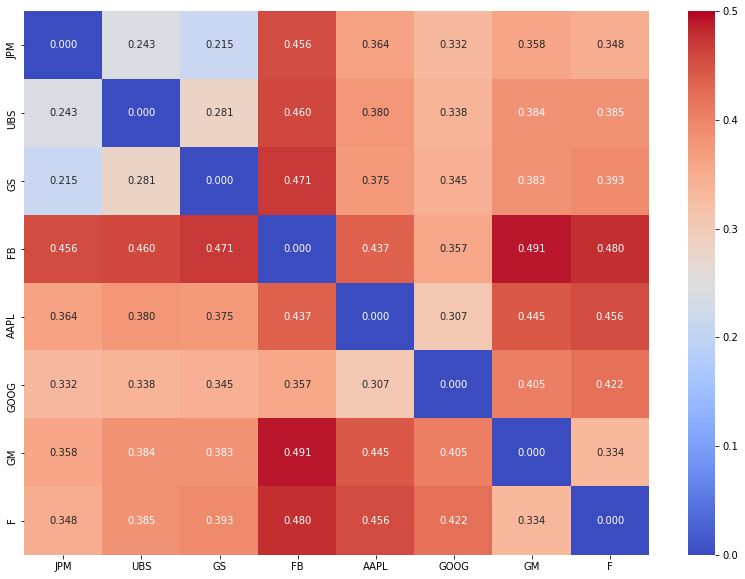

In [ ]:
# Explore the result
import seaborn as sns
fig = plt.figure(figsize=(14, 10))
sns.heatmap(SP500_distances, annot = True, fmt='.3f', vmin=0, vmax=0.5, cmap= 'coolwarm', xticklabels=True, yticklabels=True)
fig.show()

![progress](https://progress-bar.dev/30/?scale=100&title=Preparation&width=960&color=babaca&suffix=% "progress")

In the next three parts, use three different algorithms in clustering the dataset and store the result in same dataframe

## Agglomerative clustering

The **Dendrogram** is a convenient way of visualizing hierarchichal clusters. Below we define and create a dendrogram using `scipy` library. Vertical distance connecting various clusters represents euclidean distance between clusters. Linkage is performed by averaging the distances. 

Colors all the descendent links below a cluster node the same color if the node is the first node below the cut threshold value.<br/>
The default value is 0.7*max(Z[:,2]) (scipy and matlab)

In [ ]:
color_threshold =  0.36#@param {type:"number"}

icoord [[15.0, 15.0, 25.0, 25.0], [45.0, 45.0, 55.0, 55.0], [35.0, 35.0, 50.0, 50.0], [65.0, 65.0, 75.0, 75.0], [42.5, 42.5, 70.0, 70.0], [20.0, 20.0, 56.25, 56.25], [5.0, 5.0, 38.125, 38.125]]
dcoord [[0.0, 0.3335341437700034, 0.3335341437700034, 0.0], [0.0, 0.214714505206894, 0.214714505206894, 0.0], [0.0, 0.26175665592256286, 0.26175665592256286, 0.214714505206894], [0.0, 0.30705078981553774, 0.30705078981553774, 0.0], [0.26175665592256286, 0.3555538586275019, 0.3555538586275019, 0.30705078981553774], [0.3335341437700034, 0.39781778955563996, 0.39781778955563996, 0.3555538586275019], [0.0, 0.450150997171212, 0.450150997171212, 0.39781778955563996]]
ivl ['FB', 'GM', 'F', 'UBS', 'JPM', 'GS', 'AAPL', 'GOOG']
leaves [3, 6, 7, 1, 0, 2, 4, 5]
color_list ['g', 'r', 'r', 'r', 'r', 'b', 'b']


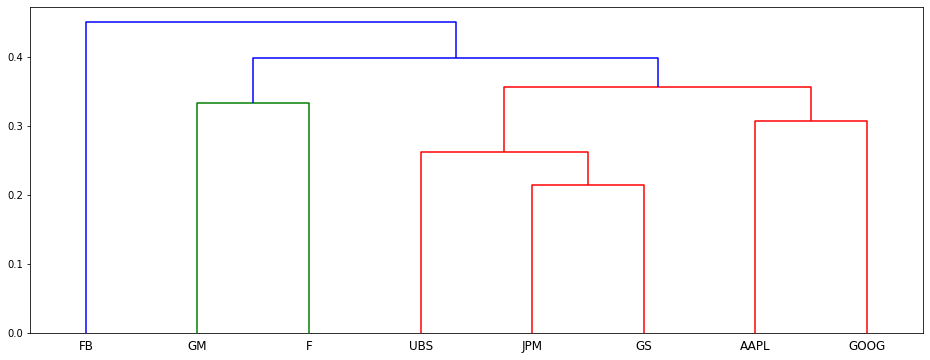

In [ ]:
# Draw figure using scipy and get data in function return as dendro
plt.figure(figsize=(16, 6))
dendro = dendrogram(linkage(SP500_pct_change.T.values, method = 'average', metric = 'euclidean'), labels=names, color_threshold=color_threshold)
# Explore data
for i in dendro:
  print(i,dendro[i])

In [ ]:
# Generate clustering result by color using code
color_map = {}
leaves_cluster = [None] * len(dendro['leaves'])
for link_x, link_y, link_color in zip(dendro['icoord'],dendro['dcoord'],dendro['color_list']):
  for (xi, yi) in zip(link_x, link_y):
    if yi == 0.0:  # if yi is 0.0, the point is a leaf
      # xi of leaves are      5, 15, 25, 35, ... (see `iv_ticks`)
      # index of leaves are   0,  1,  2,  3, ... as below
      leaf_index = (int(xi) - 5) // 10
      # each leaf has a same color of its link.
      if link_color not in color_map:
        color_map[link_color] = len(color_map)
      leaves_cluster[leaf_index] = color_map[link_color]
leaves_cluster
# Or by observation directly
# leaves_cluster = [2, 0, 0, 1, 1, 1, 1, 1]

[2, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
# Store labeld result in dataframe 
df_cluster = pd.DataFrame(leaves_cluster, columns=['Agglomerative'])
df_cluster.index = dendro['ivl']
df_cluster.sort_index(inplace=True)
df_cluster

,Agglomerative
AAPL,1
F,0
FB,2
GM,0
GOOG,1
GS,1
JPM,1
UBS,1


In [ ]:
def decode_clusters(labels, clusters):
  result = {}
  for i in range(len(clusters)):
    if clusters[i] not in result:
      result[clusters[i]] = []
    result[clusters[i]].append(labels[i])
  return list(result.values())
result_comparison = {}
result_comparison['Agglomerative'] = decode_clusters(dendro['ivl'], leaves_cluster)
result_comparison

{'Agglomerative': [['FB'], ['GM', 'F'], ['UBS', 'JPM', 'GS', 'AAPL', 'GOOG']]}

![progress](https://progress-bar.dev/60/?scale=100&title=Agglomerative&width=960&color=babaca&suffix=% "progress")

## K-means++ clustering

In [ ]:
import numpy as np
from sklearn import cluster
cl = cluster.KMeans(init='k-means++', n_clusters=3, max_iter=10000, n_init=1000, tol=0.000001)
cl.fit(np.transpose(SP500_pct_change))
cl.labels_

array([0, 0, 0, 1, 1, 1, 2, 2], dtype=int32)

In [ ]:
df_cluster['K-means']=df_cluster['Agglomerative']
df_cluster['K-means'][SP500_pct_change.columns]=cl.labels_
df_cluster.sort_index(inplace=True)
df_cluster

,Agglomerative,K-means
AAPL,1,1
F,0,2
FB,2,1
GM,0,2
GOOG,1,1
GS,1,0
JPM,1,0
UBS,1,0


In [ ]:
result_comparison['K-means'] = decode_clusters(SP500_pct_change.columns, cl.labels_)
result_comparison

{'Agglomerative': [['FB'], ['GM', 'F'], ['UBS', 'JPM', 'GS', 'AAPL', 'GOOG']],
 'K-means': [['JPM', 'UBS', 'GS'], ['FB', 'AAPL', 'GOOG'], ['GM', 'F']]}

![progress](https://progress-bar.dev/80/?scale=100&title=KMeans&width=960&color=babaca&suffix=% "progress")

## Divisive Clustering

Use the sliders to change the number of clusters in result. If cannot be categorized in this number, will use the larger nearest one.

In [ ]:
num_clusters = 3 #@param {type:"slider", min:1, max:8, step:1}

In [ ]:
import numpy as np;
import pandas as pd

all_elements = copy.copy(names)
dissimilarity_matrix = pd.DataFrame(SP500_distances,index=SP500_distances.columns, columns=SP500_distances.columns)


def avg_dissim_within_group_element(ele, element_list):
  max_diameter = -np.inf
  sum_dissm = 0
  for i in element_list:
    sum_dissm += dissimilarity_matrix[ele][i]   
    if( dissimilarity_matrix[ele][i]  > max_diameter):
      max_diameter = dissimilarity_matrix[ele][i]
  if(len(element_list)>1):
    avg = sum_dissm/(len(element_list)-1)
  else: 
    avg = 0
  return avg


def avg_dissim_across_group_element(ele, main_list, splinter_list):
  if len(splinter_list) == 0:
    return 0
  sum_dissm = 0
  for j in splinter_list:
    sum_dissm = sum_dissm + dissimilarity_matrix[ele][j]
  avg = sum_dissm/(len(splinter_list))
  return avg
    
    
def splinter(main_list, splinter_group):
  most_dissm_object_value = -np.inf
  most_dissm_object_index = None
  for ele in main_list:
    x = avg_dissim_within_group_element(ele, main_list)
    y = avg_dissim_across_group_element(ele, main_list, splinter_group)
    diff= x -y
    if diff > most_dissm_object_value:
      most_dissm_object_value = diff
      most_dissm_object_index = ele
  if(most_dissm_object_value>0):
    return  (most_dissm_object_index, 1)
  else:
    return (-1, -1)
    

def split(element_list):
  main_list = element_list
  splinter_group = []    
  (most_dissm_object_index,flag) = splinter(main_list, splinter_group)
  while(flag > 0):
    main_list.remove(most_dissm_object_index)
    splinter_group.append(most_dissm_object_index)
    (most_dissm_object_index,flag) = splinter(element_list, splinter_group)
  return (main_list, splinter_group)


def max_diameter(cluster_list):
  max_diameter_cluster_index = None
  max_diameter_cluster_value = -np.inf
  index = 0
  for element_list in cluster_list:
    for i in element_list:
      for j in element_list:
        if dissimilarity_matrix[i][j]  > max_diameter_cluster_value:
          max_diameter_cluster_value = dissimilarity_matrix[i][j]
          max_diameter_cluster_index = index
    index +=1
  if(max_diameter_cluster_value <= 0):
    return -1
  
  return max_diameter_cluster_index


current_clusters = ([all_elements])
level = 1
index = 0
result = None
while(index!=-1):
  if (result is None) and (len(current_clusters) >= num_clusters):
    result = copy.deepcopy(current_clusters)
    print(level, '*', current_clusters)
  else:
    print(level, current_clusters)
  (a_clstr, b_clstr) = split(current_clusters[index])
  del current_clusters[index]
  current_clusters.append(a_clstr)
  current_clusters.append(b_clstr)
  index = max_diameter(current_clusters)
  level +=1

if result is None:
  result = current_clusters
  print(level, '*', current_clusters)
else:
  print(level, current_clusters)

1 [['JPM', 'UBS', 'GS', 'FB', 'AAPL', 'GOOG', 'GM', 'F']]
2 [['JPM', 'UBS', 'GS', 'GM', 'F'], ['FB', 'GOOG', 'AAPL']]
3 * [['JPM', 'UBS', 'GS', 'GM', 'F'], ['GOOG', 'AAPL'], ['FB']]
4 [['GOOG', 'AAPL'], ['FB'], ['JPM', 'UBS', 'GS'], ['F', 'GM']]
5 [['GOOG', 'AAPL'], ['FB'], ['JPM', 'UBS', 'GS'], ['GM'], ['F']]
6 [['FB'], ['JPM', 'UBS', 'GS'], ['GM'], ['F'], ['AAPL'], ['GOOG']]
7 [['FB'], ['GM'], ['F'], ['AAPL'], ['GOOG'], ['JPM', 'GS'], ['UBS']]
8 [['FB'], ['GM'], ['F'], ['AAPL'], ['GOOG'], ['UBS'], ['GS'], ['JPM']]


In [ ]:
# Generate the result by code
df_cluster['Divisive'] = df_cluster['Agglomerative']
for i in range(len(result)):
  for col in result[i]:
    df_cluster['Divisive'][col]=i
# Or by observation directly
# df_cluster['Divisive'] = [2, 0, 0, 0, 0, 0, 1, 1]
df_cluster.sort_index(inplace=True)
df_cluster

,Agglomerative,K-means,Divisive
AAPL,1,1,1
F,0,2,0
FB,2,1,2
GM,0,2,0
GOOG,1,1,1
GS,1,0,0
JPM,1,0,0
UBS,1,0,0


In [ ]:
result_comparison['Divisive'] = result
result_comparison

{'Agglomerative': [['FB'], ['GM', 'F'], ['UBS', 'JPM', 'GS', 'AAPL', 'GOOG']],
 'Divisive': [['JPM', 'UBS', 'GS', 'GM', 'F'], ['GOOG', 'AAPL'], ['FB']],
 'K-means': [['JPM', 'UBS', 'GS'], ['FB', 'AAPL', 'GOOG'], ['GM', 'F']]}

![progress](https://progress-bar.dev/100/?scale=100&title=Divisive&width=960&color=babaca&suffix=% "progress")

## Exercises
### Now that you have tried out clustering, let's analyze results
* Try the exercise in Lesson 8 from the Machine Learning course
* Change the returns to Logarithmic returns and see if the results of clustering changes. What are your observations?
* You see JPM, UBS and GS in the same cluster as AAPL and GOOG for Agglometric clustering. Can you comment on why this would be?
* You see GS, JPM and UBS along with F and GM for Divisive clustering. Can you comment of why this would be?
* AAPL, GOOG and FB are in diffent clusters in Agglormerative clustering and Divisive clustering. Can you comment on why this would be?

## Reference:
### CFA Refresher Reading
1.   [Machine Learning](https://www.cfainstitute.org/en/membership/professional-development/refresher-readings/machine-learning)

---

![progress](https://progress-bar.dev/100/?scale=100&title=END!&width=980&color=babaca&suffix=% "progress")